# Proyecto 1- etapa1: Analisis de ODS

### Importacion de librerias necesarias

In [81]:
import string
import re
import unicodedata
from joblib import dump, load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.inspection import permutation_importance

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [82]:
pd.set_option('display.max_colwidth', None)

In [83]:
# Descarga de las stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [84]:
# Función para tokenizar los textos
def tokenizer(text):
    return word_tokenize(text)

In [85]:
stop_words

{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

### Preparación y carga de datos

In [86]:
df = pd.read_csv("./cat_6716.csv")
df.to_csv('./cat_6716.csv', encoding='utf-8', index=False)


In [87]:
df.shape

(3000, 2)

In [88]:
df.sample(6)

,Textos_espanol,sdg
1954,"Pueden ser significativos, especialmente si se deben conectar recursos distantes, como puede ser el caso de la energía eólica marina, si los factores de carga son bajos o si la tecnología tiene requisitos de conexión más estrictos que para la energía nuclear. Los costos de conexión a veces se integran dentro de los costos del sistema (NEA, 2012), pero con mayor frecuencia no se consideran costos del sistema y se incluyen implícitamente en el LCOE como costos a nivel de planta. La dificultad en esta evaluación es que los costos de conexión a veces corren a cargo del desarrollador de la planta ya veces los paga el operador de la red de transmisión.",7
1786,"Con este fin, las exportaciones de electricidad siguieron aumentando de forma constante en los últimos cinco años, y en 2014 se produjo un notable incremento del 62%. No obstante, las exportaciones reales de electricidad alcanzaron los 1.552 millones de kWh en 2014, lo que representa solo el 22% del potencial de exportación de electricidad previsto en el Programa. Esto puede indicar que la metodología utilizada para la previsión de la exportación de electricidad era bastante optimista y no se ajustaba plenamente a la realidad actual del potencial de exportación de Tayikistán. Se creÃ³ un nuevo Ministerio de EnergÃa y Recursos HÃdricos sobre la base del antiguo Ministerio de EnergÃa e Industria y el antiguo Ministerio de RecuperaciÃ³n de Tierras y Recursos HÃdricos.",7
156,"El evento nacional, â€œUna gota de agua es un grano de oroâ€ , es ampliamente celebrado todos los aÃ±os a principios de abril. Existe un entendimiento público generalizado de que el agua debe administrarse económicamente de manera sólida. Durante la década pasada quedó claro que habría escasez de agua si el volumen de agua en el río Amu Darya disminuyera debido al método tradicional de uso del agua.",6
2747,"Este trabajo es un capítulo de un próximo libro sobre The Essentials of International Criminal Law que será publicado por Aspen Publishers como parte de su serie Essentials. En este capítulo se analiza el controvertido concepto de terrorismo según el derecho internacional, centrándose en los esfuerzos por criminalizar el fenómeno. En particular, analiza los principales obstáculos para lograr una definición ómnibus del delito con especial énfasis en la intersección de las prohibiciones contra el terrorismo y el derecho internacional humanitario. Capítulos adicionales en el texto abordan la historia de ICL, las fuentes de ICL, los principales crímenes y defensas internacionales, y el razonamiento y la retórica de ICL. Se espera su publicación en octubre de 2008.",16
1059,"Si el aumento de CAPEX lleva a reducir los costos de combustible y tal vez otros OPEX, se debe encontrar un acuerdo entre el propietario y el fletador. Por ejemplo, la producción que va desde unas pocas toneladas al día hasta millones de toneladas al año, el almacenamiento en tanques atmosféricos o en tanques presurizados, el almacenamiento de menos de 30 m3 hasta el almacenamiento de varios cientos de miles de m3, y el transporte por mar, ferrocarril o carretera. La figura 12 proporciona una descripción general de la complejidad.",7
2718,"Introducción: Los tomadores de decisiones en políticas de salud están lidiando con decisiones cada vez más complejas y éticamente controvertidas en un momento en que los ciudadanos exigen una mayor participación en estos procesos de decisión. Objetivos: Evaluar y revisar un conjunto de principios rectores para el diseño de procesos de participación pública generados a partir de una síntesis de los marcos de diseño y evaluación de la participación pública que se pueden utilizar para informar el diseño y la evaluación de futuros procesos de participación pública en el sector de la salud. Métodos: Seis grupos focales realizados en cinco provincias canadienses integrados por ciudadanos con considerable experiencia en procesos de participación pública. Resultados y discusión: Nuest

Se cuentan los diferentes valores que se encuentran en la variable objetivo sdg para evidenciar la distribución de estos y analizar su importancia relativa.

In [89]:
df["sdg"].value_counts(dropna=False, normalize=True)

6     0.333333
7     0.333333
16    0.333333
Name: sdg, dtype: float64

Normalizamos el texto convirtiendo todas las letras a minúsculas. Esto evita que el modelo considere palabras en mayúsculas y minúsculas como diferentes.

In [90]:
df['Textos_espanol'] = df['Textos_espanol'].str.lower()

Eliminamos caracteres especiales, signos de puntuación y otros caracteres que no son esenciales para el análisis de texto. Esto puede mejorar la consistencia en los datos y reducir el ruido. Además, dejamos todos los caracteres acentuados sin el acento.

In [91]:
def limpiar_texto(texto):
    # Normaliza a la forma no acentuada
    texto = unicodedata.normalize('NFKD', texto)
    # Utiliza una expresión regular para eliminar caracteres no alfabéticos estándar
    return ''.join([c for c in texto if not unicodedata.combining(c)])

# Aplica la función de limpieza a la columna "Textos_espanol"
df['Textos_espanol'] = df['Textos_espanol'].apply(limpiar_texto)

Eliminamos las stop words ya que no aportan significancia al modelo de clasificación.

In [92]:
# Aplicar eliminación de stop words a la columna 'Textos_espanol'
df['Textos_espanol'] = df['Textos_espanol'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


Realizamos un proceso de derivación a las palabras del texto, lo que hace que se reduzca la variabilidad de las palabras en un texto, de modo que palabras relacionadas se mapeen a una forma común, permitiendo tratar palabras relacionadas como si fueran idénticas.

In [93]:
stemmer = SnowballStemmer("spanish")

#Funcion encargada de la derivación de un texto
def derivar_texto(texto):
    return ' '.join([stemmer.stem(word) for word in texto.split()])

    df['Textos_espanol'] = df['Textos_espanol'].apply(derivar_texto)


In [94]:
df.sample(3)

,Textos_espanol,sdg
1133,"empresas servicios publicos capacidad tecnica, financiera comercial integrada puede disponible lugares. 2011, invirtieron 7 000 millones dolares proyectos eficiencia energetica financiados contribuyentes, produjo reduccion energia estimada 117 twh. 2012, habia 25 normas recursos eficiencia energetica 9 adoptaron politicas. ( foster wallace dahlberg 2013).",7
1922,"tanto, cuestiones organizacion mercado importantes determinar competitividad relativa diferentes combustibles. tambien pueden abrir brecha beneficios costos privados sociales diferentes combustibles. haciendo abstraccion momento pequenas cantidades emisiones construccion, produccion electricidad base nuclear libre carbono operaciones.",7
2535,"acnur creado virtud articulo 22 carta naciones unidas organo subsidiario asamblea general. practica acnur respecto retornados va mas alla mera proteccion. asamblea general encomendado alto comisionado trabaje refugiados bajo paraguas ""buenos oficios"" incluso trabaje pais desplazados internos. examinar diversas fuentes derecho aplicables situaciones crisis aguda, senalar aspecto labor acnur paises. vision tradicional trabajo acnur proteccion personas traves frontera. situaciones crisis aguda marco juridico internacional adicional especifico refugiados. legislacion internacional derechos humanos aplica momento cualquier persona encuentre dentro jurisdiccion estado, sujeta unicamente excepciones legitimas debidamente declaradas. palabras clave: crisis aguda, derecho internacional derechos humanos, acnur, carta naciones unidas",16


### División de los datos en entrenamiento y prueba

En esta sección, estamos particionando los datos en dos grupos distintos: uno se destina al entrenamiento y el otro al testing. Dado que estamos empleando machine learning supervisado, esto implica que utilizaremos un conjunto de datos para enseñar a nuestro modelo, utilizando las etiquetas que ciertos valores deben tener. Luego, emplearemos el conjunto de prueba para verificar si nuestro modelo es capaz de asignar las etiquetas de manera precisa a un conjunto de datos para el cual no conoce las etiquetas previamente. Evaluaremos su desempeño utilizando las métricas de error pertinentes.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(df["Textos_espanol"], df["sdg"], test_size = 0.2, stratify = df["sdg"], random_state = 1)

In [96]:
X_train.shape

(2400,)

In [97]:
pd.Series(y_train).value_counts(normalize=True)

7     0.333333
6     0.333333
16    0.333333
Name: sdg, dtype: float64

In [98]:
X_test.shape

(600,)

In [99]:
pd.Series(y_test).value_counts(normalize=True)

16    0.333333
6     0.333333
7     0.333333
Name: sdg, dtype: float64

### Vectorización de los datos de texto

En esta sección, estamos convirtiendo las palabras en un único vector. Esto es necesario debido a que la vectorización de datos de texto es esencial en el análisis de texto por clasificación, ya que convierte el texto en una forma que es comprensible y utilizable por los algoritmos de aprendizaje automático, como son los vectores, lo que le permite al modelo aprender y realizar clasificaciones.

Antes de haber realizado los ajustes en los datos en los pasos anteriores, donde se hizo una limpieza y transformación de los datos de tal forma que facilitaran el modelo de clasificación, se realizó una vectorización que se evidencia en la siguiente imagen donde se puede evidenciar un tamaño del vocabulario cercano a las 20.000 palabras.

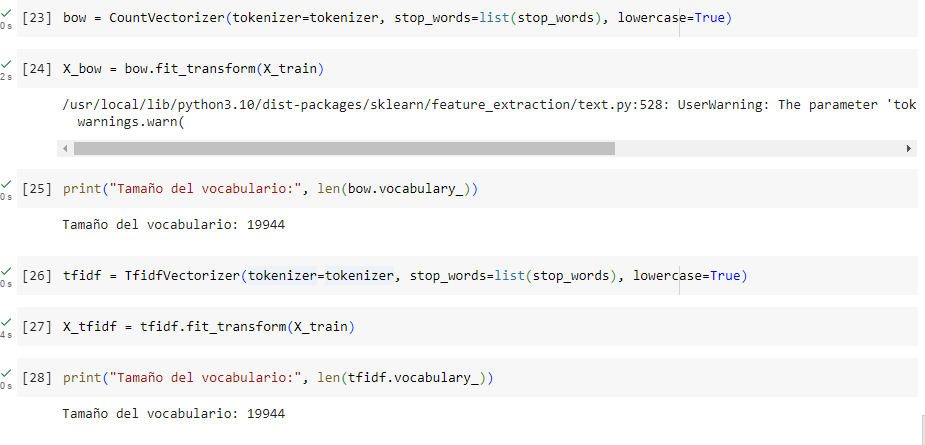

Ahora tras haber realizado dichas eliminaciones y transformaciones al dataframe encontramos vectores más pequeños, con un poco más de 100 palabras menos que el vector encontrado anteriormente.

Esto es una buena señal, haber disminuido el tamaño del vector en un bajo porcentaje hace que los datos se mantengan consistentes, es decir, no se ha perdido información valiosa ni eliminado más de la cuenta palabras necesarias para el modelo de clasificación.

In [100]:
bow = CountVectorizer(tokenizer=tokenizer, stop_words=list(stop_words), lowercase=True)

In [101]:
X_bow = bow.fit_transform(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [102]:
print("Tamaño del vocabulario:", len(bow.vocabulary_))

Tamaño del vocabulario: 19816


In [103]:
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words=list(stop_words), lowercase=True, max_features=12701)

In [104]:
X_tfidf = tfidf.fit_transform(X_train)

In [105]:
print("Tamaño del vocabulario:", len(tfidf.vocabulary_))

Tamaño del vocabulario: 12701


### Modelo Random Forest Classifier Bow
##### Modelo entrenado por: David Rincón


Este modelo utiliza el clasificador Random Forest con una representación vectorial de tipo Bag of Words (BoW) en un conjunto de 3000 datos. El algoritmo crea un árbol de decisión donde asigna importancia a ciertos valores, en este caso, palabras, para determinar a que tipo de ODS pertenece.

In [106]:
bow_model = RandomForestClassifier(random_state = 2)

In [107]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

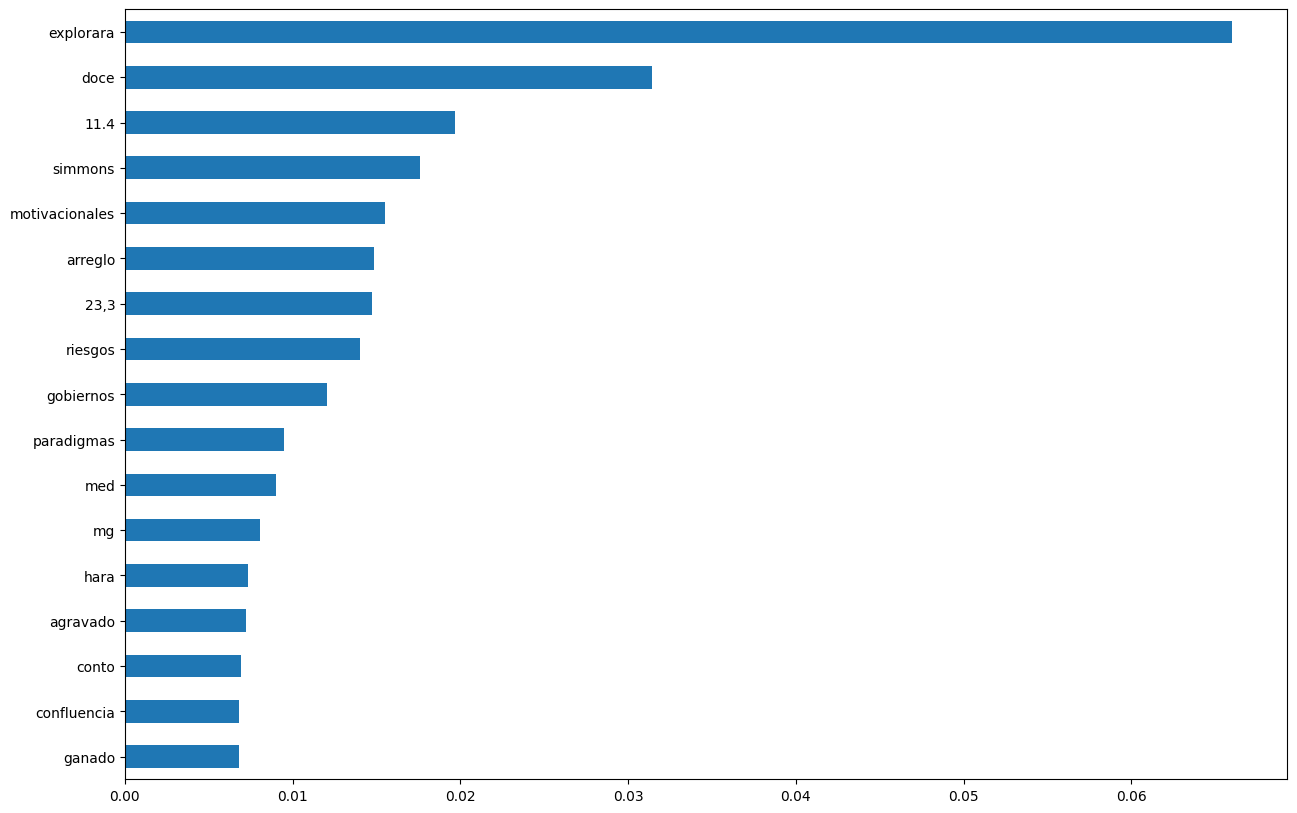

In [108]:
pd.Series(bow_model.feature_importances_, index = bow.vocabulary_).sort_values().tail(17).plot.barh(figsize = (15, 10))

In [109]:
bow_estimators = bow_model.estimators_
print('Numero de árboles:', len(bow_estimators))
print('Profundidad de los árboles:', np.mean([tree.get_depth() for tree in bow_estimators]))

Numero de árboles: 100
Profundidad de los árboles: 98.97


In [110]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

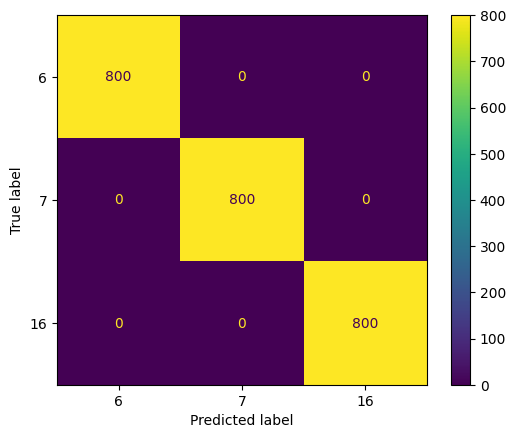

In [111]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

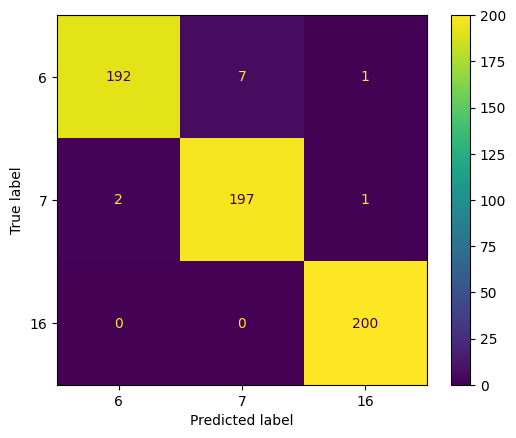

In [112]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [113]:
# Para casos no binarios, es común calcular las métricas para cada clase
print('Precision:', precision_score(y_train, y_train_bow_predict, average = None))
print('Recall:', recall_score(y_train, y_train_bow_predict, average = None))
print('F1:', f1_score(y_train, y_train_bow_predict, average = None))

Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
F1: [1. 1. 1.]


In [114]:
# Para casos no binarios, es común calcular las métricas para cada clase
print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: [0.98969072 0.96568627 0.99009901]
Recall: [0.96  0.985 1.   ]
F1: [0.97461929 0.97524752 0.99502488]


#####Conclusiones

Los resultados de la implementación del algoritmo clasificador Random Forest utilizando BoW para clasificar la variable objetivo ODS en tres categorías son positivos. Las métricas de precisión, recall y puntuación F1, todas alrededor del 98%, indican que el modelo es efectivo en la clasificación de las categorías de ODS. La alta precisión sugiere que la mayoría de las predicciones son correctas, y el recall muestra que el modelo captura la mayoría de las instancias de cada categoría. En general, estos porcentajes encontrados respaldan la robustez del modelo para esta tarea. No obstante, es importante considerar la posibilidad de overfitting y, por lo tanto, se recomienda una evaluación más amplia antes de su implementación en un entorno de producción.

### Modelo Random Forest Classifier TFIDF
##### Modelo entrenado por: David Rincón

El modelo clasificador Random Forest en combinación con un vector de características basado en TF-IDF para analizar una colección de 3000 datos de texto. La particularidad de TF-IDF radica en su capacidad para asignar ponderaciones a las palabras según su frecuencia de aparición en las reseñas, lo que facilita la captura más precisa de la importancia real de cada palabra en el texto. El algoritmo construye un conjunto de árboles de decisión en los cuales otorga relevancia a determinados valores, en este caso, las palabras, con el propósito de determinar a que ODS pertenece.

In [115]:
tfidf_model = RandomForestClassifier(random_state = 3)

In [116]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

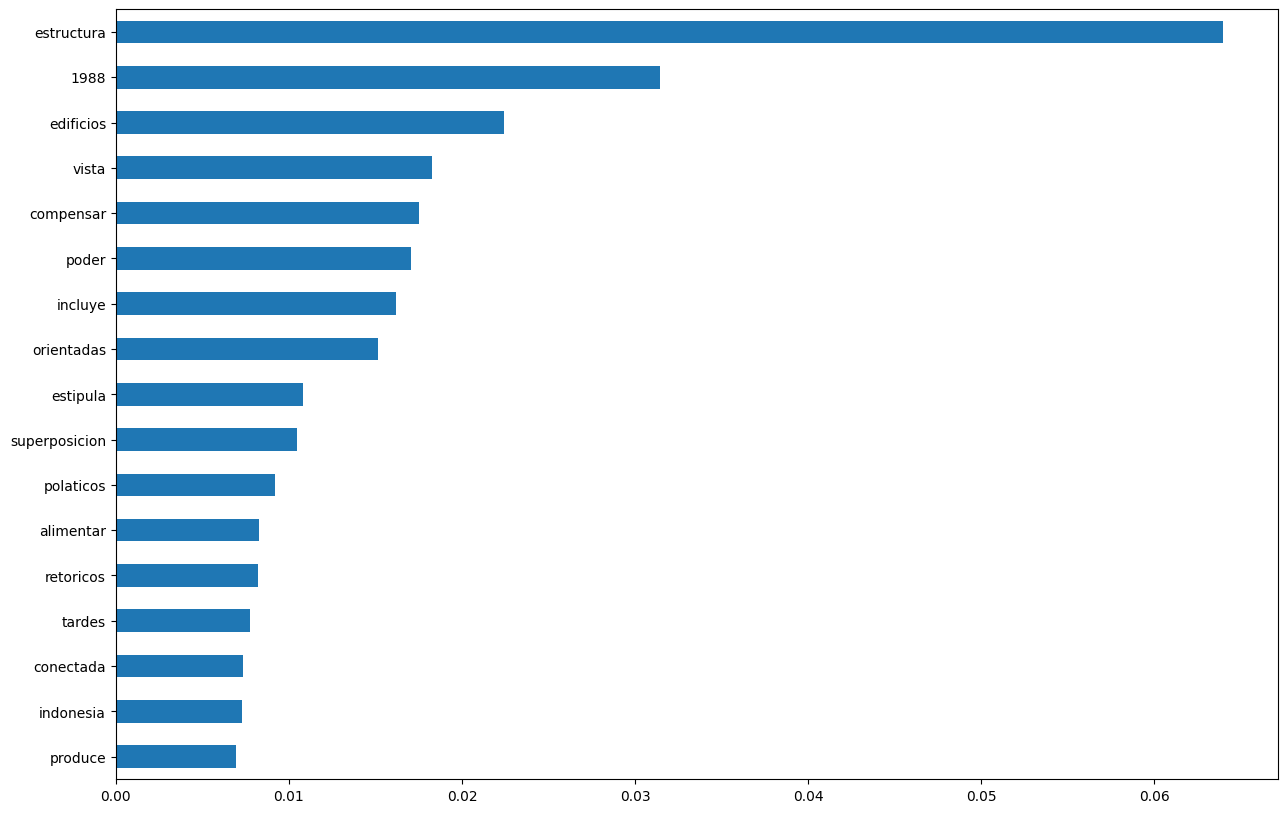

In [117]:
pd.Series(tfidf_model.feature_importances_, index = tfidf.vocabulary_).sort_values().tail(17).plot.barh(figsize = (15, 10))

In [118]:
tfidf_estimators = tfidf_model.estimators_
print('Numero de árboles:', len(tfidf_estimators))
print('Profundidad de los árboles:', np.mean([tree.get_depth() for tree in tfidf_estimators]))

Numero de árboles: 100
Profundidad de los árboles: 86.24


In [119]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test))

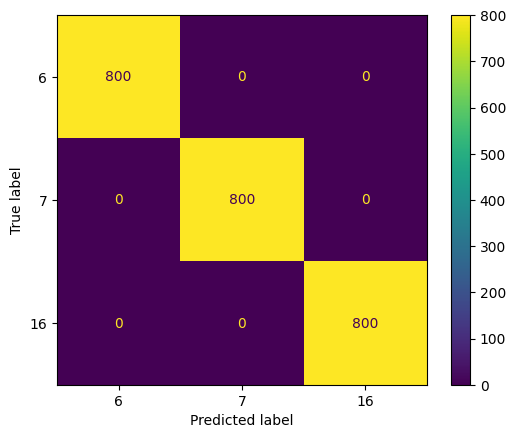

In [120]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

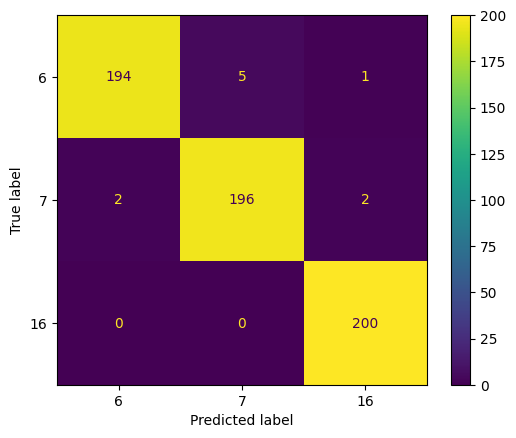

In [121]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [122]:
# Para casos no binarios, es común calcular las métricas para cada clase
print('Precision:', precision_score(y_train, y_train_tfidf_predict, average = None))
print('Recall:', recall_score(y_train, y_train_tfidf_predict, average = None))
print('F1:', f1_score(y_train, y_train_tfidf_predict, average = None))

Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
F1: [1. 1. 1.]


In [123]:
# Para casos no binarios, es común calcular las métricas para cada clase
print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: [0.98979592 0.97512438 0.98522167]
Recall: [0.97 0.98 1.  ]
F1: [0.97979798 0.97755611 0.99255583]


##### Conclusiones

Los resultados obtenidos al implementar el algoritmo clasificador Random Forest utilizando TF-IDF para la clasificación de la variable objetivo ODS en tres categorías diferentes son alentadores. Las métricas de precisión, recall y puntuación F1, con valores cercanos al 98%, indican que el modelo es eficaz en la clasificación de las distintas categorías de ODS. La alta precisión sugiere que la mayoría de las predicciones son correctas en sus respectivas categorías, y el recall muestra que el modelo es capaz de capturar la mayoría de las instancias de cada categoría. En general, estos resultados indican que el modelo es robusto y adecuado para la clasificación de las categorías de ODS en el conjunto de datos. Sin embargo, hay que contemplar la posibilidad de que se presente un problema de overfitting y por ello es importante evaluarlo y probarlo a mayor escala.

###Modelo Navie Bayes

es un clasificador basado en el modelo de Bayes ingenuo multinomial que se utiliza con frecuencia en tareas de clasificación de texto en NLP, para la clasificacion de texto NLP se debe de utilizar Vecotrizar con TF-IDF para aprovechar el poder de los algoritmos de aprendizaje automático.

In [124]:
nb_model = MultinomialNB()
nb_model.fit(X_tfidf, y_train)

MultinomialNB()

In [125]:
feature_importances = np.exp(nb_model.feature_log_prob_)[1,:] - np.exp(nb_model.feature_log_prob_)[0,:]

<Axes: >

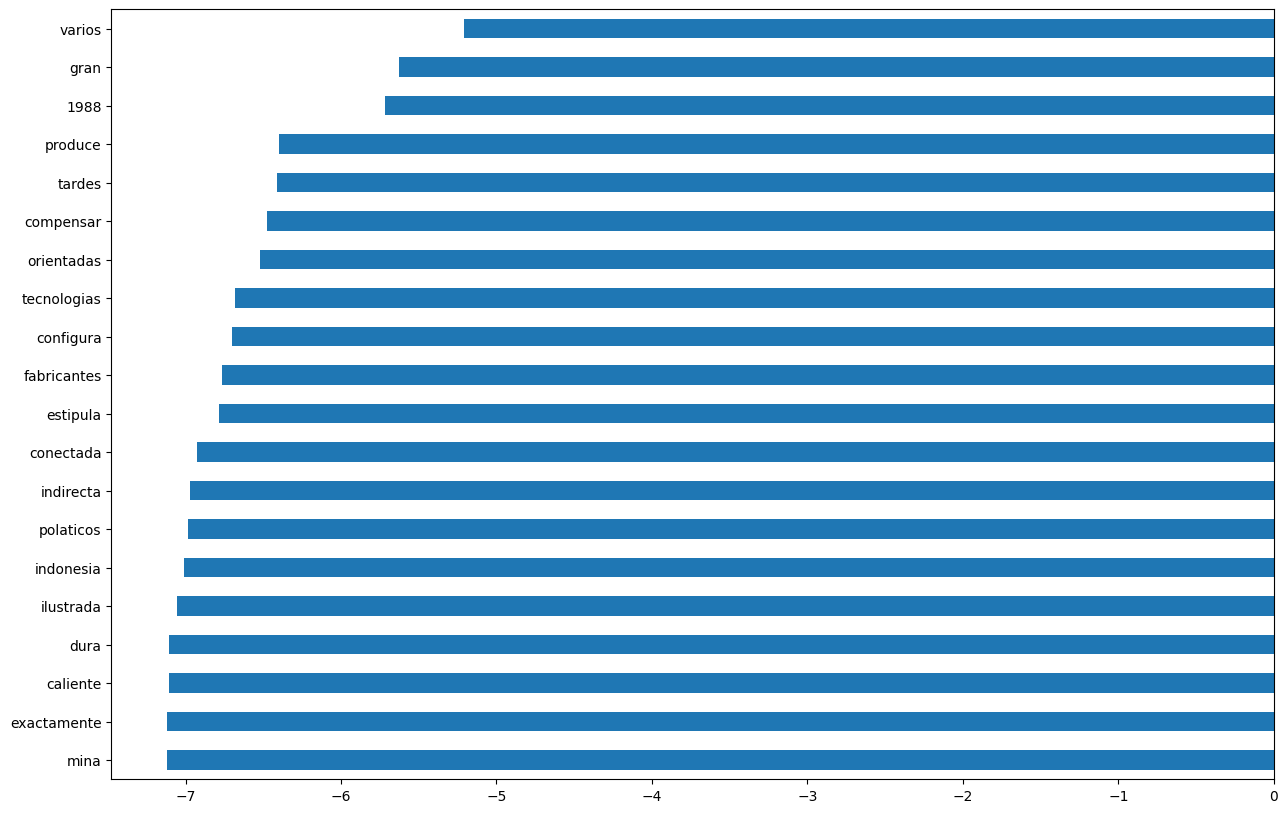

In [126]:
pd.Series(nb_model.feature_log_prob_[1], index = tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15,10))

In [127]:
y_train_nb_predict = nb_model.predict(X_tfidf)
y_test_nb_predict = nb_model.predict(tfidf.transform(X_test))

In [128]:
print('Number of classes:', len(nb_model.classes_))
print('Class labels:', nb_model.classes_)
print('Number of features:', len(nb_model.feature_log_prob_[0]))
print('Number of non-zero features:', np.count_nonzero(nb_model.feature_log_prob_))
print('Prior probabilities:', nb_model.class_log_prior_)
print('Feature log probabilities:', nb_model.feature_log_prob_)

Number of classes: 3
Class labels: [ 6  7 16]
Number of features: 12701
Number of non-zero features: 38103
Prior probabilities: [-1.09861229 -1.09861229 -1.09861229]
Feature log probabilities: [[-9.50920484 -9.0349911  -6.90536036 ... -7.98156431 -9.79596846
  -9.79596846]
 [-9.79740002 -8.8429109  -6.68228337 ... -8.75594365 -9.79740002
  -9.45476623]
 [-9.81524357 -9.81524357 -9.54275907 ... -7.65624456 -9.64802703
  -9.81524357]]


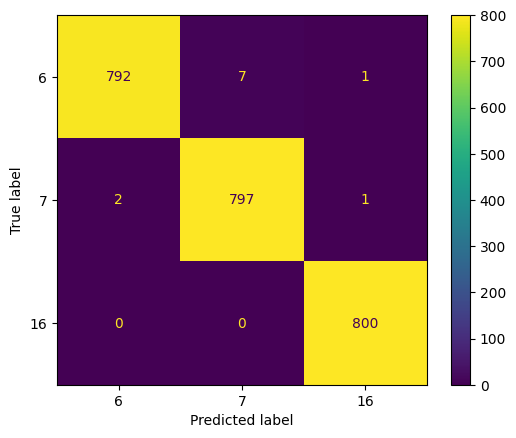

In [129]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_nb_predict)

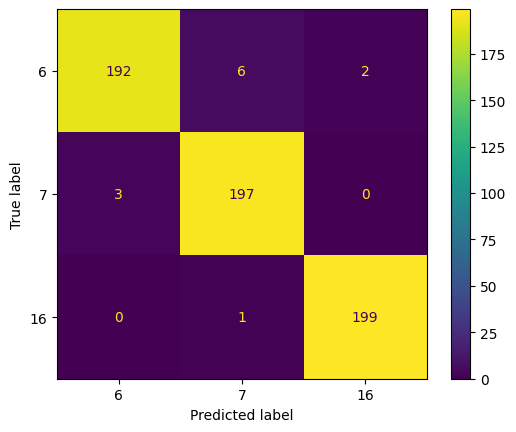

In [130]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_nb_predict)

In [131]:
print('Precision:', precision_score(y_train, y_train_nb_predict, average = None))
print('Recall:', recall_score(y_train, y_train_nb_predict, average = None))
print('F1:', f1_score(y_train, y_train_nb_predict, average=None))

Precision: [0.99748111 0.99129353 0.99750623]
Recall: [0.99    0.99625 1.     ]
F1: [0.99372647 0.99376559 0.99875156]


In [132]:
print('Precision:', precision_score(y_test, y_test_nb_predict, average = None))
print('Recall:', recall_score(y_test, y_test_nb_predict, average = None))
print('F1:', f1_score(y_test, y_test_nb_predict, average=None))

Precision: [0.98461538 0.96568627 0.99004975]
Recall: [0.96  0.985 0.995]
F1: [0.9721519  0.97524752 0.9925187 ]


##### Conclusiones
Los resultados obtenidos al realizar la implementacion de del algoritmo multinomial de naive bayes utilizando TF-IDF como vectorizacion se obtuvo 3 clasificaciones de los datos para los 3 ODS objetivos del proyecto. al analisar los resultados obtenidos en el test se puede observar que las metricas de Precision, Recall y F1 estan por encima del 96%, estos valores indican que este algoritmo de claisficacion de texto resulta ser robusto y solido para poder realizar predicciones sobre los ODS.

### Gradient BOOsting

El gradient boosting construye modelos predictivos de forma iterativa, en donde cada modelo corrige los errores del anterior. En el caso de este proyecto, el algoritmo ajusta continuamente a las instancias mal clasificadas, por lo que se crea un modelo final fuerte y preciso.

In [133]:
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)

In [134]:
gb_model.fit(X_tfidf, y_train)

GradientBoostingClassifier(random_state=42)

<Axes: >

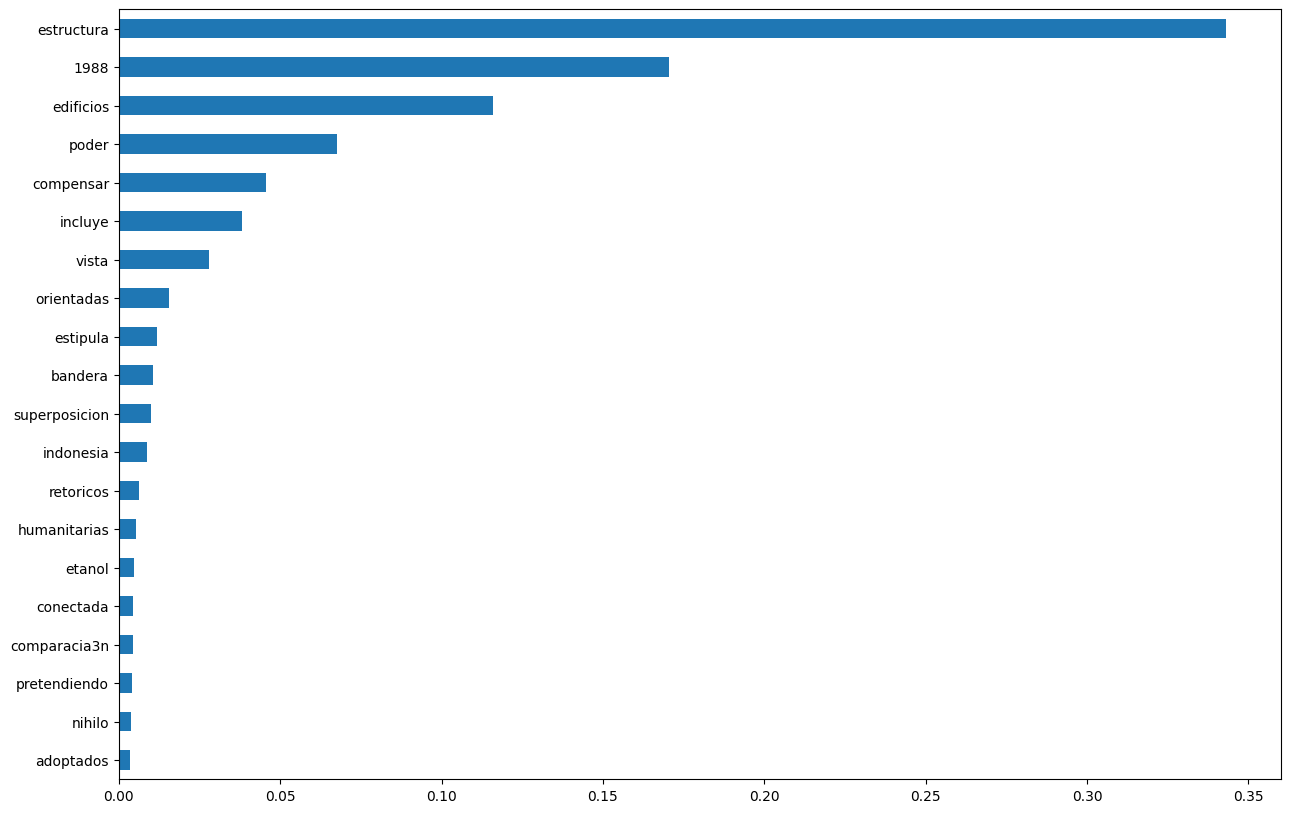

In [135]:
pd.Series(gb_model.feature_importances_, index = tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15,10))

In [136]:
y_train_gb_predict = gb_model.predict(X_tfidf)
y_test_gb_predict = gb_model.predict(tfidf.transform(X_test))

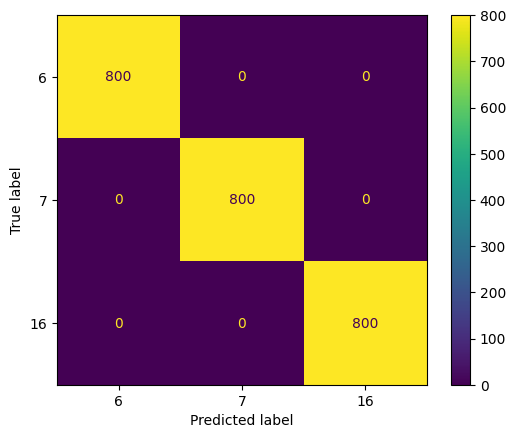

In [137]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_gb_predict)

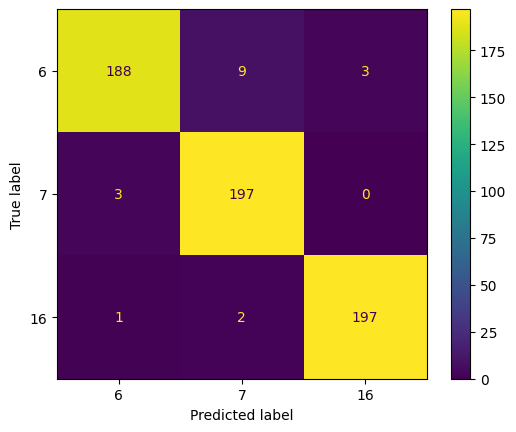

In [138]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_gb_predict)

In [139]:
print('Precision:', precision_score(y_train, y_train_gb_predict, average = None))
print('Recall:', recall_score(y_train, y_train_gb_predict, average = None))
print('F1:', f1_score(y_train, y_train_gb_predict, average=None))

Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
F1: [1. 1. 1.]


In [140]:
print('Precision:', precision_score(y_test, y_test_gb_predict, average = None))
print('Recall:', recall_score(y_test, y_test_gb_predict, average = None))
print('F1:', f1_score(y_test, y_test_gb_predict, average=None))

Precision: [0.97916667 0.94711538 0.985     ]
Recall: [0.94  0.985 0.985]
F1: [0.95918367 0.96568627 0.985     ]


##### Conclusiones
El algoritmo de Gradient Boosting demostró ser eficiente en la clasificación de textos. Las palabras más influyentes para determinar la clasificación fueron "explorará", "doce" y "11.4". A pesar de que solo 18 textos fueron mal clasificados en el conjunto de prueba, las métricas revelan una alta capacidad predictiva: con precisiones superiores al 94%, recalls superiores al 94.5% y puntuaciones F1 superiores al 95%. Esto indica que el modelo tiene un equilibrio sólido entre precisión y recall, y es robusto en su capacidad de clasificación.

###Prediccion de datos no clasificados

##### exportacion de modelo seleccionado


In [141]:
dump(tfidf_model,"modelo_seleccionado.joblib")

['modelo_seleccionado.joblib']

In [142]:
pipeline_loaded = load('modelo_seleccionado.joblib')

In [143]:
df_prediction = pd.read_csv("./SinEtiquetatest_cat_6716.csv")
df_prediction.to_csv('./SinEtiquetatest_cat_6716.csv', encoding='utf-8', index=False)

In [144]:
df_prediction.sample(3)

,Textos_espanol,sdg
135,"Las emisiones de gases de efecto invernadero (GEI) procedentes de la combustión de combustibles fósiles han sido la principal causa del calentamiento global antropogénico. El uso de la energía ha alcanzado una escala en la que se están traspasando los límites planetarios de una serie de procesos esenciales del sistema Tierra, incluso en términos de calentamiento global y pérdida de biodiversidad, lo que probablemente conducirá a un cambio medioambiental catastrófico (Rockstrom y otros, 2009). En 2005, los combustibles fósiles representaban el 85% de la combinación energética primaria mundial, mientras que la energía nuclear con bajas emisiones de carbono representaba el 6%, la hidroelectricidad el 3% y la biomasa el 4%.",NaN
487,"El apoyo a las energías renovables podría fomentar la innovación y la difusión de tecnologías de reducción de emisiones, más allá de los incentivos proporcionados por el EU ETS. Sin embargo, el análisis de la OCDE muestra que cuando existe un precio del carbono, la aplicación de otras herramientas de política, incluidos los subsidios y objetivos de energías renovables o biocombustibles, puede conducir a la superposición y socavar la rentabilidad (OCDE, 2009c). A pesar de la simplificación de los procedimientos administrativos y de permisos, éstos todavía se consideran el principal obstáculo para el desarrollo del sector de las energías renovables (IEA, 2009a).",NaN
63,"En caso afirmativo, ¿cómo se asegura el Gobierno de que puede dar cabida a un aumento de la generación de electricidad basada en energías renovables? Además de reducir los costes de generación, los mercados mayoristas aumentan la flexibilidad de la red eléctrica y permiten una asignación más rentable de la generación de electricidad. En efecto, mientras que la generación de electricidad a partir de energías renovables está sujeta a fluctuaciones (incluida la dependencia de las condiciones meteorológicas y la hora del día), la demanda debe satisfacerse siempre.",NaN


##### estandarizacion de los datos

In [145]:
df['Textos_espanol'] = df['Textos_espanol'].str.lower()

In [146]:
def limpiar_texto(texto):
    # Normaliza a la forma no acentuada
    texto = unicodedata.normalize('NFKD', texto)
    # Utiliza una expresión regular para eliminar caracteres no alfabéticos estándar
    return ''.join([c for c in texto if not unicodedata.combining(c)])

# Aplica la función de limpieza a la columna "Textos_espanol"
df_prediction['Textos_espanol'] = df_prediction['Textos_espanol'].apply(limpiar_texto)

In [147]:
# Aplicar eliminación de stop words a la columna 'Textos_espanol'
df_prediction['Textos_espanol'] = df_prediction['Textos_espanol'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


In [148]:
stemmer = SnowballStemmer("spanish")

#Funcion encargada de la derivación de un texto
def derivar_texto(texto):
    return ' '.join([stemmer.stem(word) for word in texto.split()])

    df_prediction['Textos_espanol'] = df_prediction['Textos_espanol'].apply(derivar_texto)

##### vectorizacion de los datos sin etiquetar.
al vectorizar los datos se obtuvo que la cantidad de features presentes en estos datos era de 12701, asi se requierio una modificacion en la vectorizacion de los datos de entrenamiento de los algoritmos para que concuerden la cantidad de features a evaluar.

In [149]:
Prediction_tfidf = tfidf.fit_transform(df_prediction['Textos_espanol'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


##### prediccion de los datos.

In [150]:
df_prediction["sdg"]= pipeline_loaded.predict(Prediction_tfidf)

In [151]:
df_prediction.sample(3)

,Textos_espanol,sdg
922,"Como actores estatales, EMSP estan acogidas doctrinas tradicionales derecho internacional dominadas estados. Sin embargo, derecho internacional si mismo logrado seguir ritmo evolucion actores estatales, aplican fuertes nociones soberania Westfalia. Se argumenta insuficiencias estructurales interponen camino regulacion internacional EMSP, lugar defectos derechos humanos internacionales derecho humanitario per se. Al analizar comprension responsabilidad legal, problemas estructurales pasan primer plano, argumenta que, lugar intentar resolver disputa esencialmente ideologica funciones inherentes estado, regimenes regulatorios deberian centrarse obligaciones positivas EMSP. , interacciones ellos. Aplicando resultados analisis, evaluan regimenes regulatorios actuales propuestos revelan deficiencias.",16
268,"Este proceso contribuido crecimiento regiones megaurbanas (Jones Douglass 2008) gran demanda agua recursos naturales. Estos cambios intensificado demanda agua tambien sido altamente contaminantes agua. Todos desarrollos afectan sistemas agua traves desvio agua, trayendo nuevos usos agua, creando cambios ecologicos permitiendo extraccion mas rapida recursos naturales madera. Tambien pueden desplazar gran numero habitantes y, casos, asentamientos larga historia nucleos culturales.",7
537,"Con respecto particular asentamientos tierras agricolas tierras bajas norte pais, inundaciones ocurrieron mayor frecuencia ultimos anos (casi anualmente) causaron danos graves. Sin embargo, mayoria represas mal disenadas ahora, razones seguridad, operan mitad capacidad, limita utilidad prevencion inundaciones. A pesar extraccion ilegal grava disminuyo 20 % 2000 menos 5 % 2011, impacto aun afecta lechos rios infraestructura actualidad.",7


In [152]:
df_prediction["sdg"].value_counts()

16    534
7     366
6      80
Name: sdg, dtype: int64

### exportacion de la prediccion de los datos


In [153]:
ruta_archivo_csv = "predicciones.csv"
df_prediction.to_csv(ruta_archivo_csv, index=False)